In [42]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import datasets, layers, Sequential, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, experimental, BatchNormalization

In [49]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



2022-12-22 14:56:43.404937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 14:56:43.405978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 14:56:43.406775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 14:56:43.407507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 14:56:43.408115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [50]:
import tensorflow.keras.backend as K
K.tensorflow_backend._get_available_gpus()

AttributeError: module 'keras.api._v2.keras.backend' has no attribute 'tensorflow_backend'

In [52]:
tf.compat.v1.keras.backend._get_available_gpus()

AttributeError: module 'keras.api._v1.keras.backend' has no attribute '_get_available_gpus'

In [48]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [2]:
!unzip ../input/diabetic-retinopathy-detection/trainLabels.csv.zip

Archive:  ../input/diabetic-retinopathy-detection/trainLabels.csv.zip
  inflating: trainLabels.csv         


In [3]:
!apt install p7zip-full -y
!7z x ../input/diabetic-retinopathy-detection/train.zip.001 "-i!train/11*.jpeg" -y # restrict extracted file to about 100 for the disk restriction
!mkdir data
!mv train data/train_11

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-7build1).
0 upgraded, 0 newly installed, 0 to remove and 93 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../input/diabetic-retinopathy-detectio                                                1 file, 8388608000 bytes (8000 MiB)

Extracting archive: ../input/diabetic-retinopathy-detection/train.zip.001
  0% 1 Ope          --
Path = ../input/diabetic-retinopathy-detection/train.zip.001
Type = Split
Physical Size = 8388608000
Volumes = 5
Total Physical Size = 34988445506
----
Path = train.zip
Size = 34988445506
--
Path = train.zip
Type = zip
Physical Size = 34988445506
64-bit = +

      0% 7 - train/11008_right.jpe                           

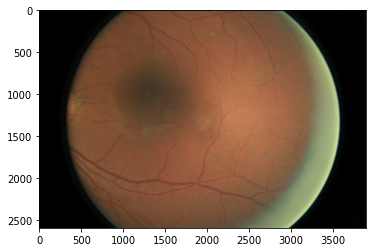

In [5]:
from PIL import Image

img = Image.open("./data/train_11/1116_right.jpeg")

import matplotlib.pyplot as plt

plt.imshow(img)

In [7]:
import os
import pandas as pd
base_image_dir = os.path.join('.', 'data/train_11')
df = pd.read_csv(os.path.join('./trainLabels.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True)#shuffle dataframe
df['level'] = df['level'].astype(str)
df.head(10)

,level,path
0,0,./data/train_11/11926_left.jpeg
1,0,./data/train_11/11127_left.jpeg
2,2,./data/train_11/11040_left.jpeg
3,0,./data/train_11/11474_right.jpeg
4,0,./data/train_11/11789_right.jpeg
5,0,./data/train_11/11665_right.jpeg
6,2,./data/train_11/11026_left.jpeg
7,0,./data/train_11/1199_right.jpeg
8,2,./data/train_11/11815_left.jpeg
9,2,./data/train_11/1178_right.jpeg


In [8]:
df["level"].value_counts()

0    608
2    148
1     64
3     37
4     15
Name: level, dtype: int64

In [9]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

175

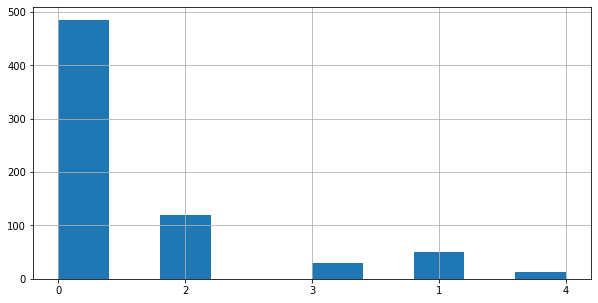

In [10]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [ ]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [11]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

In [28]:
type(train_datagen)

keras.preprocessing.image.ImageDataGenerator

In [12]:
x_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=".",
        x_col="path",
        y_col="level",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
x_test = test_datagen.flow_from_dataframe(
        val_df,
        x_col="path",
        y_col="level",
        directory=".",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 697 validated image filenames belonging to 5 classes.
Found 175 validated image filenames belonging to 5 classes.


In [39]:
#CNN
model = Sequential()

#1st Module
model.add(Conv2D(32, (3, 3),  padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(BatchNormalization())

#2nd Module
model.add(Conv2D(64, (3, 3),  padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3),  padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3),  padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

#3rd Module
model.add(Conv2D(128, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), (1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

#4th Module
model.add(Conv2D(256, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), (1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

#4th Module
model.add(Conv2D(512, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), (1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten the layers
model.add(Flatten())

#Fully connected layers
model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 128, 128, 64)    

In [45]:
model.compile(keras.optimizers.Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['Accuracy'])

In [46]:
model.fit(x_train, epochs=5, batch_size=32, validation_data=x_test)

Epoch 1/5
22/22 [==============================] - 118s 5s/step - loss: 63.6556 - Accuracy: 0.5065 - val_loss: 10630.7520 - val_Accuracy: 0.0343
Epoch 2/5
22/22 [==============================] - 109s 5s/step - loss: 1.2040 - Accuracy: 0.6657 - val_loss: 590.6437 - val_Accuracy: 0.0171
Epoch 3/5
 4/22 [====>.........................] - ETA: 1:15 - loss: 1.0249 - Accuracy: 0.6719

KeyboardInterrupt: 

In [ ]:
 # define the grid search parameters
batch_size = [16, 32, 64, 128, 256]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.bestscore, grid_result.bestparams))
means = grid_result.cvresults['mean_test_score']
stds = grid_result.cvresults['std_test_score']
params = grid_result.cvresults['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Transfer Learn Resnet

In [57]:
resnet = tf.keras.applications.ResNet50(weights='imagenet', 
                                        include_top = False,
                                        input_shape=(224, 224, 3))

layer = tf.keras.layers.GlobalMaxPooling2D()(resnet.output)
layer = Flatten()(layer)

#Fully connected layers
layer=Dense(1024, activation='relu')(layer)
# model.add(Dropout(0.25))
output = tf.keras.layers.Dense(5, activation = 'softmax')(layer)

model1 = tf.keras.Model(inputs=resnet.input, outputs=output)

In [58]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [59]:
model1.compile(keras.optimizers.Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['Accuracy'])

In [60]:
model1.fit(x_train, epochs=5, batch_size=32, validation_data=x_test)

Epoch 1/5
22/22 [==============================] - 154s 5s/step - loss: 37.8758 - Accuracy: 0.6255 - val_loss: 2244345361072128.0000 - val_Accuracy: 0.0800
Epoch 2/5
22/22 [==============================] - 110s 5s/step - loss: 2.1338 - Accuracy: 0.6844 - val_loss: 306314176.0000 - val_Accuracy: 0.7029
Epoch 3/5
22/22 [==============================] - 108s 5s/step - loss: 1.4744 - Accuracy: 0.6815 - val_loss: 32365.2656 - val_Accuracy: 0.7029
Epoch 4/5
22/22 [==============================] - 115s 5s/step - loss: 1.5111 - Accuracy: 0.6743 - val_loss: 0.9805 - val_Accuracy: 0.7029
Epoch 5/5
22/22 [==============================] - 122s 6s/step - loss: 1.5095 - Accuracy: 0.6786 - val_loss: 9.9045 - val_Accuracy: 0.7029
